##**Import**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##**Data reading**

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Group,Area,AREAU,CSERIAL,quarter,rimweight,scrser,struct3,tenharm,ycserial,...,hqwork,hjobever,HSTUDY,hselfem,hsupvis,hnemple,hsempo,hftptw,rnssec8,hnssec8
0,1,1001,151001,1001509,21,0.231809,10015090,1,1,151001509,...,-3,-3,-3,-3,-3,-3,-3,-3,8.0,8.0
1,1,1001,151001,1001511,21,0.459260,10015110,1,1,151001511,...,-3,-3,-3,-3,-3,-3,-3,-3,7.0,7.0
2,2,1001,151001,1001513,21,0.405449,10015130,1,1,151001513,...,-3,-3,-3,-3,-3,-3,-3,-3,2.0,2.0
3,2,1001,151001,1001521,21,0.254792,10015210,2,3,151001521,...,-3,-3,-3,-3,-3,-3,-3,-3,7.0,7.0
4,1,1001,151001,1001523,21,0.231809,10015230,1,1,151001523,...,-3,-3,-3,-3,-3,-3,-3,-3,3.0,3.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7502 entries, 0 to 7501
Columns: 1818 entries, Group to hnssec8
dtypes: float64(3), int64(1815)
memory usage: 104.1 MB


In [7]:
df_questions = pd.read_csv('/content/drive/MyDrive/questions.csv')
df_questions.head()

,Row,Topic,Variable name,Variable label,Source
0,1,Admin variables,Group,USED IN SECTION 6 ROTATION (To set whether res...,Sample
1,2,Admin variables,Area,Area code (Field),Derived variable
2,3,Admin variables,AREAU,Area code with year (PSU reference),Derived variable
3,4,Admin variables,CSERIAL,Address serial number,Derived variable
4,5,Admin variables,quarter,Quarter within rolling year,Derived variable


##**Constants**

In [8]:
gender_dict = {'male': 1, 'female': 2}
gender_count = {'male': df['sex1_3cat'].value_counts()[gender_dict['male']],
                'female': df['sex1_3cat'].value_counts()[gender_dict['female']]}

sports_dict = {}
sports_filter_col = [col for col in df if col.startswith('SPORTY')]
df1 = df_questions[df_questions['Variable name'].str.startswith('SPORTY')]
for _, row in df1.iterrows():
  sport = row['Variable label'].replace("In last 4 weeks, has respondent done ", "")
  sports_dict[row['Variable name']] = sport
inv_sports_dict = {v: k for k, v in sports_dict.items()}

freq_sports_dict = {}
freq_sports_filter_col = [col for col in df if col.startswith('ACTFREQ')]
df1 = df_questions[df_questions['Variable name'].str.startswith('ACTFREQ')]
for _, row in df1.iterrows():
  sport = row['Variable label'].replace("During the past 4 weeks, how many times in total did you do ", "")
  freq_sports_dict[row['Variable name']] = sport
freq_category = {1: 'Less than 1 a week', 2: 'At least 1 a week but less than 2 a week', 3: 'At least 2 but less than 3 times a week', 4: 'At least 3 times a week'}

reasons_sports_dict = {}
reasons_sports_filter_col = [col for col in df if col.startswith('illbar')]
df1 = df_questions[df_questions['Variable name'].str.startswith('illbar')]
for _, row in df1.iterrows():
  if row['Variable name'] not in ['illbar11', 'illbar12']:
    sport = row['Variable label'].replace("Factors that affect ability to participate in or attend cultural and sporting activities in last 12 months - ", "")
    reasons_sports_dict[row['Variable name']] = sport

age_dict = {1: '16-19', 2: '20-24', 3: '25-34', 4: '35-44', 5: '45-54', 6: '55-64', 7: '65-74', 8: '75-84', 9: '85+'}

family_dict = {1: 'Without child(ren)', 2: 'Without partner, but with child(ren)', 3: 'With partner and with child(ren)'}
family_count = {1: df.struct3.value_counts()[1], 2: df.struct3.value_counts()[2], 3: df.struct3.value_counts()[3]}

income_dict = {1: 'Up to £5,199', 2: '£5,200 up to £10,399', 3: '£10,400 up to £15,599', 4: '£15,600 up to £20,799', 5: '£20,800 up to £25,999',
               6: '£26,000 up to £31,199', 7: '£31,200 up to £36,399', 8: '£36,400 up to £41,599', 9: '£41,600 up to £46,799', 10: '£46,800 up to £51,999', 11: '£52,000 or more'}
area_dict = {'urban': 1, 'rural': 2}
area_count = {'urban': df['areatyp'].value_counts()[area_dict['urban']], 'rural': df['areatyp'].value_counts()[area_dict['rural']]}

arts_yourself = []
arts_attend = []
for i in range(31):
  arts_yourself.append(f"artp{i}")
  arts_attend.append(f"arta{i}")

arts_yourself_dict = {}
arts_yourself_filter_col = [col for col in df if col in arts_yourself]
for _, row in df_questions.iterrows():
  if row['Variable name'] in arts_yourself:
    art = row['Variable label'].replace("In the last 12 months have you done any of these activities - ", "")
    arts_yourself_dict[row['Variable name']] = art


arts_attend_dict = {}
arts_attend_filter_col = [col for col in df if col in arts_attend]
for _, row in df_questions.iterrows():
  if row['Variable name'] in arts_attend:
    art = row['Variable label'].replace("In the last 12 months, have you been to any of these events - ", "")
    arts_attend_dict[row['Variable name']] = art

freetime_dict = {}
freetime_filter_col = [col for col in df if col.startswith('freetime')]
freetime_filter_col.remove('freetime27')
df1 = df_questions[df_questions['Variable name'].str.startswith('freetime')]
for _, row in df1.iterrows():
  freetime = row['Variable label'].replace("Free time activity - ", "")
  freetime_dict[row['Variable name']] = freetime
inv_freetime_dict = {k: v for v, k in freetime_dict.items()}

##**Exploratory Data Analysis**

### *General situation in sport preferences*

In [9]:
def pie_chart(curr):
  if curr:
    values = [df['anysport'].value_counts()[1], df['anysport'].value_counts()[0]]
    phrase = 'in last 4 weeks?'
  else:
    df1 = df[df['growupc'] > 0]
    values = [df['growupc'].value_counts()[1], df['growupc'].value_counts()[2]]
    phrase = 'while was growing up?'
  labels = ["Yes", "No"]
  fig = go.Figure(data=[go.Pie(labels=labels, values = values)])
  fig.update_layout(
    title=f"Did the respondent take part in any type of sport activities {phrase}")
  fig.show()

pie_chart(True)
pie_chart(False)


In [10]:
def k_popular_sports(k, percentage_mode=False):
  df1 = df[sports_filter_col]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/df.shape[0])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  values = dict(Counter(values).most_common(k))
  fig = go.Figure([go.Bar(x=list(values.keys()), y=list(values.values()))])
  fig.update_layout(xaxis={'categoryorder':'total descending'})
  phrase = ""
  if percentage_mode:
    phrase = " (by percentage)"
  fig.update_layout(title=f"{k} most popular sport activities (which were done in last 4 weeks by respondent){phrase}")
  fig.show()
  return list(values.keys()), values
most_popular_sports = k_popular_sports(10)
most_popular_sports = k_popular_sports(10, True)

In [11]:
def freq_most_popular_sports():
  freq_df = pd.DataFrame({'Sport': [], 'Frequency category': [], 'Percentage': []})
  inv_freq = {v: k for k, v in freq_sports_dict.items()}
  for sport in most_popular_sports[0]:
    freq_var = inv_freq[sport]
    count = 0
    for i in range(1, 5):
      count += df[freq_var].value_counts()[i]
    for i in range(1, 5):
      freq_df = freq_df.append({'Sport': sport, 'Frequency category': freq_category[i], 'Percentage': df[freq_var].value_counts()[i]*100/count}, ignore_index = True)
  fig = px.bar(freq_df, x="Sport", y="Percentage", color="Frequency category", title="Frequency of top-10 popular sport activities")
  fig.show()

freq_most_popular_sports()

In [12]:
def reasons_for_not_participating(percentage_mode = False):
  df1 = df[reasons_sports_filter_col]
  values = {}
  for col in df1:
    if col not in ['illbar11', 'illbar12']:
      if percentage_mode:
        values[reasons_sports_dict[col]] = df1[col].value_counts()[1]*100/(df1[col].shape[0] - df1[col].value_counts()[-3])
      else:
        values[reasons_sports_dict[col]] = df1[col].value_counts()[1]
  fig = go.Figure([go.Bar(x=list(values.keys()), y=list(values.values()))])
  fig.update_layout(xaxis={'categoryorder':'total descending'})
  fig.update_layout(title = "Most common reasons for not participating")
  fig.show()
reasons_for_not_participating(True)

### *Sport activity and preferences by gender*


In [ ]:
def pie_chart_gender(gender, curr):
  df1 = df[df['sex1_3cat'] == gender_dict[gender]]
  if curr:
    values = [df1['anysport'].value_counts()[1], df1['anysport'].value_counts()[0]]
    phrase = 'in last 4 weeks?'
  else:
    df1 = df1[df1['growupc'] > 0]
    values = [df1['growupc'].value_counts()[1], df1['growupc'].value_counts()[2]]
    phrase = 'while was growing up?'
  labels = ["Yes", "No"]
  fig = go.Figure(data=[go.Pie(labels=labels, values = values)])
  fig.update_layout(
    title=f"Did the {gender} respondent take part in any type of sport activities {phrase}")
  fig.show()

pie_chart_gender('male', True)
pie_chart_gender('female', True)
pie_chart_gender('male', False)
pie_chart_gender('female', False)

In [ ]:
def k_popular_sports_gender(gender, k, percentage_mode = False):
  df1 = df[df['sex1_3cat'] == gender_dict[gender]]
  df1 = df1[sports_filter_col]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/gender_count[gender])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  values = dict(Counter(values).most_common(k))
  fig = go.Figure([go.Bar(x=list(values.keys()), y=list(values.values()))])
  fig.update_layout(xaxis={'categoryorder':'total descending'})
  phrase = ""
  if percentage_mode:
    phrase = " (by percentage)"
  fig.update_layout(title=f"{k} most popular sport activities (which were done in last 4 weeks by respondent) among {gender}s{phrase}")
  fig.show()
k_popular_sports_gender('male', 10, True)
k_popular_sports_gender('female', 10, True)

In [ ]:
def popular_sports_gender(gender, percentage_mode=False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] in most_popular_sports[0]]
  df1 = df[filter_pop].loc[df['sex1_3cat'] == gender]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/gender_count[gender])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values
most_popular_sports_female = popular_sports_gender(2)
most_popular_sports_male = popular_sports_gender(1)

def table_popular_sports_gender():
  female_sports = []
  for sport_type in most_popular_sports[0]:
    female_sports.append(round(most_popular_sports_female[sport_type] * 100 / gender_count['female'] , 1))

  male_sports = []
  for sport_type in most_popular_sports[0]:
    male_sports.append(round(most_popular_sports_male[sport_type] * 100 / gender_count['male'], 1))

  x = PrettyTable()
  x.add_column("Sport Type", most_popular_sports[0])
  x.add_column("Female", female_sports)
  x.add_column("Male", male_sports)
  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=female_sports,
    name='Female engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=male_sports,
    name='Male engagement',
    marker_color='cornflowerblue'
))
  fig.update_layout(title='Comparison of gender engagement in most popular sports')
  fig.show()
table_popular_sports_gender()

+-------------------------------------------------------------------+--------+------+
|                             Sport Type                            | Female | Male |
+-------------------------------------------------------------------+--------+------+
|      Walking for leisure (includes dog walking and rambling)      |  67.6  | 66.0 |
|                         Walking for travel                        |  33.4  | 35.6 |
|                        Cycling for leisure                        |  9.1   | 16.4 |
|                              Swimming                             |  11.6  | 9.8  |
| A session combining several gym or fitness machines or activities |  8.2   | 10.5 |
|                          Exercise machine                         |  6.9   | 9.9  |
|                         Running or jogging                        |  6.7   | 9.4  |
|                            Free weights                           |  5.4   | 9.6  |
|                       Body weight exercises         

In [23]:
def sport_comparison_gender(particular_sport, gender, percentage_mode = False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] == particular_sport]
  df1 = df[filter_pop].loc[df['sex1_3cat'] == gender]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/gender_count[gender])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values


def table_sport_comparison_gender(particular_sport):
  particular_sport_female = sport_comparison_gender(particular_sport, 2)
  particular_sport_male = sport_comparison_gender(particular_sport, 1)
  female_sports = [round(particular_sport_female[particular_sport] * 100 / gender_count['female'] , 1)]
  male_sports = [(round(particular_sport_male[particular_sport] * 100 / gender_count['male'], 1))]

  x = PrettyTable()
  x.add_column("Sport Type", [particular_sport])
  x.add_column("Female", female_sports)
  x.add_column("Male", male_sports)
  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=female_sports,
    name='Female engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=male_sports,
    name='Male engagement',
    marker_color='cornflowerblue'
))
  fig.update_layout(title=f'Comparison of gender engagement in {particular_sport} by percentage of sample')
  fig.show()
table_sport_comparison_gender("Football")
table_sport_comparison_gender("Zumba or dance fitness")
table_sport_comparison_gender("Yoga")
table_sport_comparison_gender("Cardio class")
table_sport_comparison_gender("Golf")

+------------+--------+------+
| Sport Type | Female | Male |
+------------+--------+------+
|  Football  |  0.5   | 8.5  |
+------------+--------+------+


+------------------------+--------+------+
|       Sport Type       | Female | Male |
+------------------------+--------+------+
| Zumba or dance fitness |  3.9   | 0.4  |
+------------------------+--------+------+


+------------+--------+------+
| Sport Type | Female | Male |
+------------+--------+------+
|    Yoga    |  6.8   | 2.0  |
+------------+--------+------+


+--------------+--------+------+
|  Sport Type  | Female | Male |
+--------------+--------+------+
| Cardio class |  3.0   | 2.3  |
+--------------+--------+------+


+------------+--------+------+
| Sport Type | Female | Male |
+------------+--------+------+
|    Golf    |  0.8   | 5.1  |
+------------+--------+------+


### *Sport activity and preferences by age*

In [19]:
# percentes of people different age who are engaged in the each of top 10 popular sports table

def popular_sports_age(age, percentage_mode=False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] in most_popular_sports[0]]
  df1 = df[filter_pop].loc[df['agelong'] == age]
  values = {}
  for col in df1:
    try:
      values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values

y = PrettyTable()
y.add_column("Sport Type", most_popular_sports[0])

age_sports ={}
for i in range(1, 10):
  i_num = df.agelong.value_counts()[i]
  age_sports[str(age_dict[i])] = []
  for sport_type in most_popular_sports[0]:
    age_sports[str(age_dict[i])].append(round(popular_sports_age(i)[sport_type] / i_num * 100, 1))
  y.add_column(str(str(age_dict[i])), age_sports[str(age_dict[i])])

print(y)

+-------------------------------------------------------------------+-------+-------+-------+-------+-------+-------+-------+-------+------+
|                             Sport Type                            | 16-19 | 20-24 | 25-34 | 35-44 | 45-54 | 55-64 | 65-74 | 75-84 | 85+  |
+-------------------------------------------------------------------+-------+-------+-------+-------+-------+-------+-------+-------+------+
|      Walking for leisure (includes dog walking and rambling)      |  55.1 |  64.7 |  68.3 |  71.7 |  72.4 |  68.4 |  71.8 |  55.3 | 31.1 |
|                         Walking for travel                        |  51.7 |  55.2 |  47.8 |  43.9 |  35.4 |  28.3 |  23.5 |  22.0 | 11.6 |
|                        Cycling for leisure                        |  11.7 |  12.7 |  14.8 |  18.0 |  18.7 |  11.8 |  8.0  |  3.1  | 1.1  |
|                              Swimming                             |  11.7 |  12.1 |  13.2 |  16.9 |  12.6 |  9.5  |  8.6  |  3.6  | 0.0  |
| A session c

In [20]:
def sport_type_ages(sptype):
  sport_age = []
  for i in age_dict.values():
    sport_age.append(age_sports[i][sptype])
  return sport_age

for i in range(10):
  data = sport_type_ages(i)
  fig = go.Figure([go.Bar(x=list(age_dict.values()), y=list(data))])
  fig.update_layout(title=f"{most_popular_sports[0][i]}")
  fig.show()



In [22]:
def sport_comparison_age(particular_sport, age):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] == particular_sport]
  df1 = df[filter_pop].loc[df['agelong'] == age]
  values = {}
  for col in df1:
    try:
      values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values

def table_sport_comparison_age(particular_sport):
  y = PrettyTable()
  y.add_column("Sport Type", [particular_sport])
  age_sports ={}
  for i in range(1, 10):
    i_num = df.agelong.value_counts()[i]
    age_sports[str(age_dict[i])] = [round(sport_comparison_age(particular_sport, i)[particular_sport] / i_num * 100, 1)]
    y.add_column(str(str(age_dict[i])), age_sports[str(age_dict[i])])
  print(y)
  data = []
  for value in age_sports.values():
    data.append(value[0])
  fig = go.Figure([go.Bar(x=list(age_dict.values()), y=data)])
  fig.update_layout(title=f"{particular_sport} engagement by different age groups")
  fig.show()

table_sport_comparison_age("Football")
table_sport_comparison_age("Yoga")
table_sport_comparison_age("Golf")

+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
| Sport Type | 16-19 | 20-24 | 25-34 | 35-44 | 45-54 | 55-64 | 65-74 | 75-84 | 85+ |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
|  Football  |  22.0 |  12.7 |  8.7  |  5.7  |  3.9  |  1.0  |  0.4  |  0.1  | 0.0 |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+


+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
| Sport Type | 16-19 | 20-24 | 25-34 | 35-44 | 45-54 | 55-64 | 65-74 | 75-84 | 85+ |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
|    Yoga    |  2.9  |  5.6  |  5.8  |  6.7  |  6.1  |  4.4  |  3.3  |  1.7  | 0.0 |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+


+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
| Sport Type | 16-19 | 20-24 | 25-34 | 35-44 | 45-54 | 55-64 | 65-74 | 75-84 | 85+ |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+
|    Golf    |  3.4  |  2.9  |  2.0  |  1.7  |  3.4  |  3.4  |  3.3  |  3.0  | 0.4 |
+------------+-------+-------+-------+-------+-------+-------+-------+-------+-----+


### *Sport activity and preferences by household income*

In [24]:
# percentes of people with different household income who are engaged in the each of top 10 popular sports table

def popular_sports_income(income, percentage_mode=False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] in most_popular_sports[0]]
  df1 = df[filter_pop].loc[df['advincomey15'] == income]
  values = {}
  for col in df1:
    try:
      values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values

y = PrettyTable()
y.add_column("Sport Type", most_popular_sports[0])

income_sports ={}
for i in range(1, 12):
  i_num = df.advincomey15.value_counts()[i]
  income_sports[str(income_dict[i])] = []
  for sport_type in most_popular_sports[0]:
    income_sports[str(income_dict[i])].append(round(popular_sports_income(i)[sport_type] / i_num * 100, 1))
  y.add_column(str(str(income_dict[i])), income_sports[str(income_dict[i])])

print(y)

+-------------------------------------------------------------------+--------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+
|                             Sport Type                            | Up to £5,199 | £5,200 up to £10,399 | £10,400 up to £15,599 | £15,600 up to £20,799 | £20,800 up to £25,999 | £26,000 up to £31,199 | £31,200 up to £36,399 | £36,400 up to £41,599 | £41,600 up to £46,799 | £46,800 up to £51,999 | £52,000 or more |
+-------------------------------------------------------------------+--------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+
|      Walking for leisure (includes dog walki

In [25]:
def sport_type_income(sptype):
  sport_income = []
  for i in income_dict.values():
    sport_income.append(income_sports[i][sptype])
  return sport_income

for i in range(10):
  data = sport_type_income(i)
  fig = go.Figure([go.Bar(x=list(income_dict.values()), y=list(data))])
  fig.update_layout(title=f"{most_popular_sports[0][i]}")
  fig.show()

### *Sport activity and preferences by family structure*

In [ ]:
# percentes of people depending on fam type who are engaged in the each of top 10 popular sports table

def popular_sports_family(fam, percentage_mode=False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] in most_popular_sports[0]]
  df1 = df[filter_pop].loc[df['struct3'] == fam]
  values = {}
  for col in df1:
    try:
      values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values

def table_popular_sports_family():
  most_popular_sports_single = popular_sports_family(1)
  most_popular_sports_child = popular_sports_family(2)
  most_popular_sports_partnerchild = popular_sports_family(3)

  single_sports = []
  for sport_type in most_popular_sports[0]:
    single_sports.append(round(most_popular_sports_female[sport_type] / family_count[1] * 100, 1))

  child_sports = []
  for sport_type in most_popular_sports[0]:
    child_sports.append(round(most_popular_sports_child[sport_type] / family_count[2] * 100, 1))

  partnerchild_sports = []
  for sport_type in most_popular_sports[0]:
    partnerchild_sports.append(round(most_popular_sports_partnerchild[sport_type] / family_count[3] * 100, 1))

  x = PrettyTable()
  x.add_column("Sport Type", most_popular_sports[0])
  x.add_column(family_dict[1], single_sports)
  x.add_column(family_dict[2], child_sports)
  x.add_column(family_dict[3], partnerchild_sports)

  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=single_sports,
    name=f'{family_dict[1]} engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=child_sports,
    name=f'{family_dict[2]} engagement',
    marker_color='cornflowerblue'
))
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=partnerchild_sports,
    name=f'{family_dict[3]} engagement',
    marker_color='#54A24B'
))
  fig.update_layout(title='Comparison of family status engagement in most popular sports')
  fig.show()

table_popular_sports_family()

+-------------------------------------------------------------------+--------------------+--------------------------------------+----------------------------------+
|                             Sport Type                            | Without child(ren) | Without partner, but with child(ren) | With partner and with child(ren) |
+-------------------------------------------------------------------+--------------------+--------------------------------------+----------------------------------+
|      Walking for leisure (includes dog walking and rambling)      |        48.5        |                 69.1                 |               75.3               |
|                         Walking for travel                        |        23.9        |                 43.1                 |               41.1               |
|                        Cycling for leisure                        |        6.5         |                 13.4                 |               19.4               |
|         

In [29]:
def sport_comparison_family(particular_sport, fam):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] == particular_sport]
  df1 = df[filter_pop].loc[df['struct3'] == fam]
  values = {}
  for col in df1:
    try:
      values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values


def table_sport_comparison_family(particular_sport):
  sport_single = sport_comparison_family(particular_sport, 1)
  sport_child = sport_comparison_family(particular_sport, 2)
  sport_partnerchild = sport_comparison_family(particular_sport, 3)
  single_sport = [round(sport_single[particular_sport] * 100 / family_count[1] , 1)]
  child_sport = [(round(sport_child[particular_sport] * 100 / family_count[2], 1))]
  partnerchild_sport = [(round(sport_partnerchild[particular_sport] * 100 / family_count[3], 1))]

  x = PrettyTable()
  x.add_column("Sport Type", [particular_sport])
  x.add_column(family_dict[1], single_sport)
  x.add_column(family_dict[2], child_sport)
  x.add_column(family_dict[3], partnerchild_sport)
  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=single_sport,
    name=f'{family_dict[1]} engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=child_sport,
    name=f'{family_dict[2]} engagement',
    marker_color='cornflowerblue'
))
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=partnerchild_sport,
    name=f'{family_dict[3]} engagement',
    marker_color='#54A24B'
))
  fig.update_layout(title=f'Comparison of family status engagement in {particular_sport}')
  fig.show()
table_sport_comparison_family("Football")
table_sport_comparison_family("Zumba or dance fitness")
table_sport_comparison_family("Yoga")
table_sport_comparison_family("Cardio class")

+------------+--------------------+--------------------------------------+----------------------------------+
| Sport Type | Without child(ren) | Without partner, but with child(ren) | With partner and with child(ren) |
+------------+--------------------+--------------------------------------+----------------------------------+
|  Football  |        3.5         |                 1.8                  |               7.7                |
+------------+--------------------+--------------------------------------+----------------------------------+


+------------------------+--------------------+--------------------------------------+----------------------------------+
|       Sport Type       | Without child(ren) | Without partner, but with child(ren) | With partner and with child(ren) |
+------------------------+--------------------+--------------------------------------+----------------------------------+
| Zumba or dance fitness |        2.1         |                 3.7                  |               2.9                |
+------------------------+--------------------+--------------------------------------+----------------------------------+


+------------+--------------------+--------------------------------------+----------------------------------+
| Sport Type | Without child(ren) | Without partner, but with child(ren) | With partner and with child(ren) |
+------------+--------------------+--------------------------------------+----------------------------------+
|    Yoga    |        4.4         |                 5.5                  |               5.4                |
+------------+--------------------+--------------------------------------+----------------------------------+


+--------------+--------------------+--------------------------------------+----------------------------------+
|  Sport Type  | Without child(ren) | Without partner, but with child(ren) | With partner and with child(ren) |
+--------------+--------------------+--------------------------------------+----------------------------------+
| Cardio class |        2.3         |                 2.8                  |               4.0                |
+--------------+--------------------+--------------------------------------+----------------------------------+


### *Sport activity and preferences by area living type (urban or rural)*


In [ ]:
def pie_chart_area(area, curr):
  df1 = df[df['areatyp'] == area_dict[area]]
  if curr:
    values = [df1['anysport'].value_counts()[1], df1['anysport'].value_counts()[0]]
    phrase = 'in last 4 weeks?'
  else:
    df1 = df1[df1['growupc'] > 0]
    values = [df1['growupc'].value_counts()[1], df1['growupc'].value_counts()[2]]
    phrase = 'while was growing up?'
  labels = ["Yes", "No"]
  fig = go.Figure(data=[go.Pie(labels=labels, values = values)])
  fig.update_layout(
    title=f"Did the respondent which live in {area} area take part in any type of sport activities {phrase}")
  fig.show()

pie_chart_area('urban', True)
pie_chart_area('rural', True)
pie_chart_area('urban', False)
pie_chart_area('rural', False)

In [ ]:
def k_popular_sports_area(area, k, percentage_mode = False):
  df1 = df[df['areatyp'] == area_dict[area]]
  df1 = df1[sports_filter_col]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/area_count[area])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  values = dict(Counter(values).most_common(k))
  fig = go.Figure([go.Bar(x=list(values.keys()), y=list(values.values()))])
  fig.update_layout(xaxis={'categoryorder':'total descending'})
  phrase = ""
  if percentage_mode:
    phrase = " (by percentage)"
  fig.update_layout(title=f"{k} most popular sport activities by respondents who line in {area} area{phrase}")
  fig.show()
k_popular_sports_area('urban', 10, True)
k_popular_sports_area('rural', 10, True)

In [ ]:
def popular_sports_area(area, percentage_mode=False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] in most_popular_sports[0]]
  df1 = df[filter_pop].loc[df['areatyp'] == area_dict[area]]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/area_count[area])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values
most_popular_sports_rural = popular_sports_area('rural')
most_popular_sports_urban = popular_sports_area('urban')

def table_popular_sports_area():
  rural_sports = []
  for sport_type in most_popular_sports[0]:
    rural_sports.append(round(most_popular_sports_rural[sport_type] * 100 / area_count['rural'] , 1))

  urban_sports = []
  for sport_type in most_popular_sports[0]:
    urban_sports.append(round(most_popular_sports_urban[sport_type] * 100 / area_count['urban'], 1))

  x = PrettyTable()
  x.add_column("Sport Type", most_popular_sports[0])
  x.add_column("Urban", urban_sports)
  x.add_column("Rural", rural_sports)
  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=rural_sports,
    name='Rural engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=most_popular_sports[0],
    y=urban_sports,
    name='Urban engagement',
    marker_color='cornflowerblue'
))
  fig.update_layout(title='Comparison of area living type engagement in most popular sports')
  fig.show()
table_popular_sports_area()

+-------------------------------------------------------------------+-------+-------+
|                             Sport Type                            | Urban | Rural |
+-------------------------------------------------------------------+-------+-------+
|      Walking for leisure (includes dog walking and rambling)      |  64.8 |  75.1 |
|                         Walking for travel                        |  36.6 |  25.8 |
|                        Cycling for leisure                        |  12.2 |  13.4 |
|                              Swimming                             |  10.5 |  11.9 |
| A session combining several gym or fitness machines or activities |  9.6  |  8.1  |
|                          Exercise machine                         |  8.4  |  7.8  |
|                         Running or jogging                        |  8.2  |  6.9  |
|                            Free weights                           |  7.6  |  6.0  |
|                       Body weight exercises         

In [31]:
def sport_comparison_area(particular_sport, area, percentage_mode = False):
  filter_pop = [sport for sport in sports_filter_col if sports_dict[sport] == particular_sport]
  df1 = df[filter_pop].loc[df['areatyp'] == area]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/area_count[area])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  return values


def table_sport_comparison_gender(particular_sport):
  particular_sport_rural = sport_comparison_area(particular_sport, 2)
  particular_sport_urban = sport_comparison_area(particular_sport, 1)
  rural_sports = [round(particular_sport_rural[particular_sport] * 100 / area_count['rural'] , 1)]
  urban_sports = [(round(particular_sport_urban[particular_sport] * 100 / area_count['urban'], 1))]

  x = PrettyTable()
  x.add_column("Sport Type", [particular_sport])
  x.add_column("Urban", urban_sports)
  x.add_column("Rural", rural_sports)
  print(x)

  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=rural_sports,
    name='Rural engagement',
    marker_color='indianred'
))
  fig.add_trace(go.Bar(
    x=[particular_sport],
    y=urban_sports,
    name='Urban engagement',
    marker_color='cornflowerblue'
))
  fig.update_layout(title=f'Comparison of area living type engagement in {particular_sport} by percentage of sample')
  fig.show()
table_sport_comparison_gender("Football")
table_sport_comparison_gender("Zumba or dance fitness")
table_sport_comparison_gender("Yoga")
table_sport_comparison_gender("Cardio class")

+------------+-------+-------+
| Sport Type | Urban | Rural |
+------------+-------+-------+
|  Football  |  4.4  |  3.0  |
+------------+-------+-------+


+------------------------+-------+-------+
|       Sport Type       | Urban | Rural |
+------------------------+-------+-------+
| Zumba or dance fitness |  2.4  |  2.2  |
+------------------------+-------+-------+


+------------+-------+-------+
| Sport Type | Urban | Rural |
+------------+-------+-------+
|    Yoga    |  4.5  |  5.2  |
+------------+-------+-------+


+--------------+-------+-------+
|  Sport Type  | Urban | Rural |
+--------------+-------+-------+
| Cardio class |  2.8  |  2.2  |
+--------------+-------+-------+


### *Sport activity and preferences by free time activities passing*

In [32]:
def k_popular_sports_freetime(freetime, k, percentage_mode = False):
  df1 = df.loc[df[freetime] == 1]
  df1 = df1[sports_filter_col]
  values = {}
  for col in df1:
    try:
      if percentage_mode:
        values[sports_dict[col]] = (df1[col].value_counts()[1]*100/df1.shape[0])
      else:
        values[sports_dict[col]] = (df1[col].value_counts()[1])
    except KeyError:
      values[sports_dict[col]] = 0
  values = dict(Counter(values).most_common(k))
  fig = go.Figure([go.Bar(x=list(values.keys()), y=list(values.values()))])
  fig.update_layout(xaxis={'categoryorder':'total descending'})
  fig.update_layout(title = f"{k} most popular sport activities among those who in their free time: {freetime_dict[freetime]}")
  fig.show()
for freetime in freetime_filter_col:
  k_popular_sports_freetime(freetime, 10, True)

## **Models**

### *Data preprocessing*

In [34]:
col_names = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'INTACC', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'idchil']
col_names += [col for col in df if col in arts_yourself]
col_names += [col for col in df if col in arts_attend]
col_names += [col for col in df if col in freetime_filter_col]
col_names += [col for col in df if col.startswith('SPORTY')]

df_m = df[col_names]
for col_name in col_names:
  df_m = df_m.loc[df_m[col_name] != -1].loc[df_m[col_name] != -2]

# df_m = df_m.loc[df_m['advincomey15'] != -1].loc[df_m['advincomey15'] != -2]

df_m = df_m.loc[df_m['sex1_3cat'] != 3]

col_list = ['INTACC', 'sex1_3cat', 'areatyp', 'growupc', 'volworkY12', 'ANYQUAL']

df_m = df_m.replace([-3], 0)

for col_name in sports_filter_col + col_list:
  df_m[col_name] = df_m[col_name].replace([2], 0)
for col_name in col_list:
  df_m[col_name] = df_m[col_name].replace([2], 0)

### Checking for correlation in arts participation, arts attending activities and sports activities after processing the data for modelling:

In [35]:
result = df_m[arts_attend_filter_col].corr()
for _, row in result.iterrows():
  for col in result:
    if (row[col] < -0.7 or row[col] > 0.7) and row[col] != 1:
      print(row, arts_attend_dict[col])

In [36]:
result = df_m[arts_yourself_filter_col].corr()
for _, row in result.iterrows():
  for col in result:
    if (row[col] < -0.7 or row[col] > 0.7) and row[col] != 1:
      print(row, arts_attend_dict[col])

In [37]:
result = df_m[sports_filter_col].corr()
for _, row in result.iterrows():
  for col in result:
    if (row[col] < -0.7 or row[col] > 0.7) and row[col] != 1:
      print(row, sports_filter_col[col])

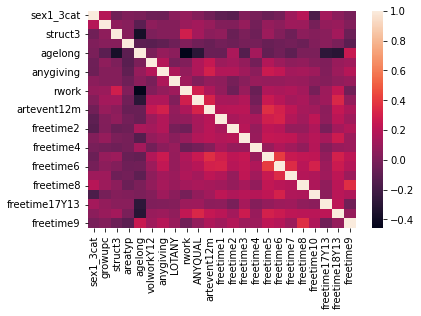

In [38]:
col_main_names = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m'] + freetime_filter_col
sns.heatmap(df_m[col_main_names].corr())

### Logit and probit models

#### Walking for leisure prediction 

**Logit**

In [ ]:
sport = "Walking for leisure (includes dog walking and rambling)"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_leisure_col = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'INTACC'] + freetime_filter_col
x = [col for col in walking_leisure_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.551451
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.128      
Dependent Variable: SPORTY1264       AIC:              8166.4609  
Date:               2022-06-01 17:53 BIC:              8332.1557  
No. Observations:   7361             Log-Likelihood:   -4059.2    
Df Model:           23               LL-Null:          -4655.2    
Df Residuals:       7337             LLR p-value:      1.6791e-237
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
sex1_3cat      -0.1133    0.0597  -1.8960  0.0580  -0.2304   0.0038
growupc         0.0778    0.0570   1.3642  0.1725

Removing insignificant features.

In [ ]:
sport = "Walking for leisure (includes dog walking and rambling)"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_leisure_col = ['areatyp', 'agelong', 'volworkY12', 'anygiving', 'ANYQUAL', 'artevent12m', 'INTACC', 'freetime2', 'freetime4', 'freetime5', 'freetime8', 'freetime17Y13', 'freetime18Y13', 'freetime9'] 
x = [col for col in walking_leisure_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.552180
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.127      
Dependent Variable: SPORTY1264       AIC:              8157.1944  
Date:               2022-06-01 17:53 BIC:              8253.8497  
No. Observations:   7361             Log-Likelihood:   -4064.6    
Df Model:           13               LL-Null:          -4655.2    
Df Residuals:       7347             LLR p-value:      1.8646e-244
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
areatyp        -0.4521    0.0662  -6.8271  0.0000  -0.5819  -0.3223
agelong        -0.1206    0.0137  -8.7742  0.0000

**Probit**

In [ ]:
sport = "Walking for leisure (includes dog walking and rambling)"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_leisure_col = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'INTACC'] + freetime_filter_col
x = [col for col in walking_leisure_col]
X = df_m[x].copy()

logit_model=sm.Probit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.551701
         Iterations 5
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.128      
Dependent Variable: SPORTY1264       AIC:              8170.1420  
Date:               2022-06-01 17:53 BIC:              8335.8368  
No. Observations:   7361             Log-Likelihood:   -4061.1    
Df Model:           23               LL-Null:          -4655.2    
Df Residuals:       7337             LLR p-value:      1.0241e-236
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
sex1_3cat      -0.0697    0.0353  -1.9721  0.0486  -0.1389  -0.0004
growupc         0.0459    0.0339   1.3558  0.1751

Removing insignificant features.

In [ ]:
sport = "Walking for leisure (includes dog walking and rambling)"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_leisure_col = ['areatyp', 'agelong', 'volworkY12', 'anygiving', 'ANYQUAL', 'artevent12m', 'INTACC', 'freetime2', 'freetime4', 'freetime5', 'freetime8', 'freetime17Y13', 'freetime18Y13', 'freetime9'] 
x = [col for col in walking_leisure_col]
X = df_m[x].copy()

logit_model=sm.Probit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.552425
         Iterations 5
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.126      
Dependent Variable: SPORTY1264       AIC:              8160.7939  
Date:               2022-06-01 18:00 BIC:              8257.4492  
No. Observations:   7361             Log-Likelihood:   -4066.4    
Df Model:           13               LL-Null:          -4655.2    
Df Residuals:       7347             LLR p-value:      1.1090e-243
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
areatyp        -0.2675    0.0384  -6.9664  0.0000  -0.3427  -0.1922
agelong        -0.0720    0.0081  -8.8374  0.0000

There is no strong preference in result, so we are atick to use Logit model for the next steps of analysis.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(logreg.score(X_test, y_test)))
y.value_counts()/y.shape[0]

Accuracy of logistic regression: 0.74


1    0.672463
0    0.327537
Name: SPORTY1264, dtype: float64

[[ 280  439]
 [ 142 1348]]


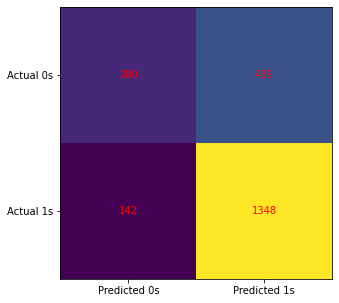

In [ ]:
confusion_matri = confusion_matrix(y_test, y_pred)
print(confusion_matri)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(confusion_matri)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matri[i, j], ha='center', va='center', color='red')
plt.show()

No handles with labels found to put in legend.


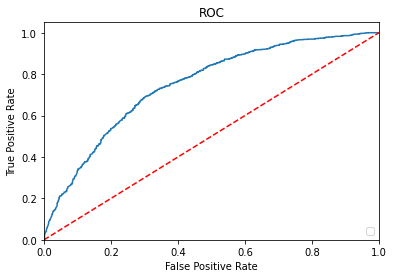

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

#### Walking for travel prediction

**Logit**

In [ ]:
sport = "Walking for travel"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_travel_col = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'INTACC'] + freetime_filter_col
x = [col for col in walking_travel_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.598768
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.070      
Dependent Variable: SPORTY121        AIC:              8863.0638  
Date:               2022-06-01 18:21 BIC:              9028.7586  
No. Observations:   7361             Log-Likelihood:   -4407.5    
Df Model:           23               LL-Null:          -4741.7    
Df Residuals:       7337             LLR p-value:      2.1053e-126
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
sex1_3cat          0.1446   0.0565   2.5592 0.0105  0.0338  0.2553
growupc           -0.1080   0.0547  -1.9734 0.0484 -0

Removing insignificant features.

In [ ]:
sport = "Walking for travel"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_travel_col = ['areatyp', 'agelong', 'volworkY12', 'ANYQUAL', 'artevent12m', 'INTACC', 'freetime2', 'freetime5', 'freetime7', 'freetime17Y13'] 
x = [col for col in walking_travel_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601693
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.066      
Dependent Variable: SPORTY121        AIC:              8878.1233  
Date:               2022-06-01 18:36 BIC:              8947.1628  
No. Observations:   7361             Log-Likelihood:   -4429.1    
Df Model:           9                LL-Null:          -4741.7    
Df Residuals:       7351             LLR p-value:      8.0491e-129
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
areatyp            0.4169   0.0606   6.8796 0.0000  0.2981  0.5357
agelong           -0.2711   0.0113 -23.9869 0.0000 -0

**Probit**

In [39]:
sport = "Walking for travel"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_travel_col = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'INTACC'] + freetime_filter_col
x = [col for col in walking_travel_col]
X = df_m[x].copy()

logit_model=sm.Probit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.598862
         Iterations 5
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.070      
Dependent Variable: SPORTY121        AIC:              8864.4422  
Date:               2022-06-02 13:02 BIC:              9030.1371  
No. Observations:   7361             Log-Likelihood:   -4408.2    
Df Model:           23               LL-Null:          -4741.7    
Df Residuals:       7337             LLR p-value:      4.1045e-126
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
sex1_3cat          0.0841   0.0341   2.4653 0.0137  0.0172  0.1509
growupc           -0.0638   0.0330  -1.9351 0.0530 -0

Removing insignificant features.

In [42]:
sport = "Walking for travel"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
walking_leisure_col = ['areatyp', 'agelong', 'volworkY12', 'anygiving', 'ANYQUAL', 'artevent12m', 'INTACC', 'freetime2', 'freetime17Y13'] 
x = [col for col in walking_leisure_col]
X = df_m[x].copy()

logit_model=sm.Probit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.602675
         Iterations 5
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.064      
Dependent Variable: SPORTY121        AIC:              8890.5741  
Date:               2022-06-02 13:02 BIC:              8952.7096  
No. Observations:   7361             Log-Likelihood:   -4436.3    
Df Model:           8                LL-Null:          -4741.7    
Df Residuals:       7352             LLR p-value:      1.1288e-126
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
areatyp            0.2447   0.0361   6.7851 0.0000  0.1740  0.3154
agelong           -0.1687   0.0071 -23.7214 0.0000 -0

There is no strong preference in result, so we are atick to use Logit model for the next steps of analysis.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(logreg.score(X_test, y_test)))
y.value_counts()/y.shape[0]

Accuracy of logistic regression: 0.67


0    0.65521
1    0.34479
Name: SPORTY121, dtype: float64

[[1276  166]
 [ 570  197]]


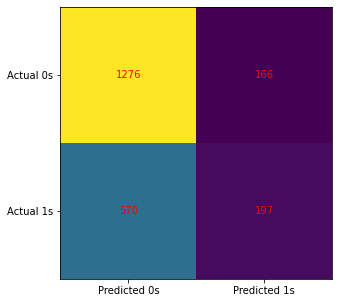

In [44]:
confusion_matri = confusion_matrix(y_test, y_pred)
print(confusion_matri)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(confusion_matri)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matri[i, j], ha='center', va='center', color='red')
plt.show()

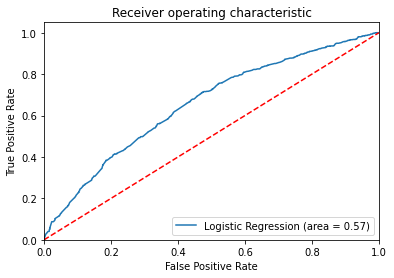

In [46]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Yoga prediction tries

In [47]:
sport = "Yoga"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
yoga_col = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'INTACC'] + freetime_filter_col
x = [col for col in yoga_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.168811
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.106     
Dependent Variable: SPORTY122121Y13  AIC:              2533.2363 
Date:               2022-06-02 13:10 BIC:              2698.9311 
No. Observations:   7361             Log-Likelihood:   -1242.6   
Df Model:           23               LL-Null:          -1389.6   
Df Residuals:       7337             LLR p-value:      7.4881e-49
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
sex1_3cat        -1.3586   0.1459  -9.3123 0.0000 -1.6445 -1.0726
growupc           0.1672   0.1199   1.3945 0.1632 -0.0678  0.4022


In [48]:
sport = "Yoga"
variable = inv_sports_dict[sport]
y = df_m[variable].copy()
yoga_col = ['sex1_3cat', 'struct3', 'areatyp', 'agelong', 'volworkY12', 'rwork', 'artevent12m', 'INTACC', 'freetime1', 'freetime2', 'freetime4', 'freetime5', 'freetime17Y13', 'freetime9']
x = [col for col in yoga_col]
X = df_m[x].copy()

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.169263
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.103     
Dependent Variable: SPORTY122121Y13  AIC:              2519.8889 
Date:               2022-06-02 13:10 BIC:              2616.5442 
No. Observations:   7361             Log-Likelihood:   -1245.9   
Df Model:           13               LL-Null:          -1389.6   
Df Residuals:       7347             LLR p-value:      1.0690e-53
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
sex1_3cat        -1.2801   0.1403  -9.1224 0.0000 -1.5551 -1.0051
struct3          -0.3615   0.0729  -4.9579 0.0000 -0.5045 -0.2186


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(logreg.score(X_test, y_test)))
y.value_counts()/y.shape[0]

Accuracy of logistic regression: 0.96


0    0.953267
1    0.046733
Name: SPORTY122121Y13, dtype: float64

[[2120    0]
 [  89    0]]


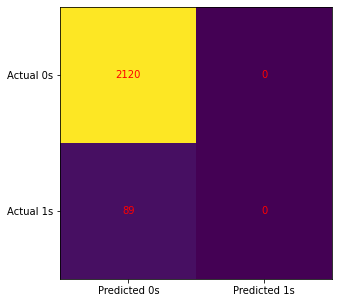

In [50]:
confusion_matri = confusion_matrix(y_test, y_pred)
print(confusion_matri)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(confusion_matri)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matri[i, j], ha='center', va='center', color='red')
plt.show()

### Happiness prediction

In [51]:
col_names = ['sex1_3cat', 'growupc', 'struct3', 'areatyp', 'agelong', 'INTACC', 'volworkY12', 'anygiving', 'LOTANY', 'rwork', 'ANYQUAL', 'artevent12m', 'idchil', 'anysport', 'HAPPY']
col_names += [col for col in df if col in freetime_filter_col]

df_m = df[col_names]
for col_name in col_names:
  df_m = df_m.loc[df_m[col_name] != -1].loc[df_m[col_name] != -2]

# df_m = df_m.loc[df_m['advincomey15'] != -1].loc[df_m['advincomey15'] != -2]

df_m = df_m.loc[df_m['sex1_3cat'] != 3]

col_list = ['INTACC', 'sex1_3cat', 'areatyp', 'growupc', 'volworkY12', 'ANYQUAL']

df_m = df_m.replace([-3], 0)

for col_name in col_list:
  df_m[col_name] = df_m[col_name].replace([2], 0)

In [52]:
formula = "HAPPY~"
for col in col_names:
  if col != "HAPPY":
    formula += f"{col}+"
formula = formula[:-1]
model = smf.ols(formula, data = df_m)
model = model.fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  HAPPY   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     13.75
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           2.23e-58
Time:                        13:17:47   Log-Likelihood:                -15678.
No. Observations:                7298   AIC:                         3.141e+04
Df Residuals:                    7271   BIC:                         3.160e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2567      0.196     31.858

In [54]:
formula = "HAPPY ~ agelong + areatyp + rwork + anysport + artevent12m + freetime1 + freetime3 + freetime4 + freetime5 + freetime6 + freetime10 + freetime18Y13 + freetime9"

model = smf.ols(formula, data = df_m)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  HAPPY   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     25.30
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           6.26e-61
Time:                        13:19:11   Log-Likelihood:                -15692.
No. Observations:                7298   AIC:                         3.141e+04
Df Residuals:                    7284   BIC:                         3.151e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4689      0.159     40.560